<br>
<br>
<center>
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/F1.svg/320px-F1.svg.png" alt="image.png">
<h1>FORMULA 1 PIT STOP ANALYSIS</h1>
</center>

<br>
<br>


# DESCRIPTION

## Main Objective

Main objective of this notebook is to answer one simple question: 

*"What is the optimal pit stop strategy for different tracks?"*

In Formula 1, pit stop strategy is crucial for several reasons:

* **Tire Wear and Degradation**: Formula 1 tires wear out over the course of a race due to the high speeds and forces they endure. Pit stops allow teams to change tires when they are worn down or when conditions change (weather/track conditions).
* **Strategy Adjustments**: Pit stops allow teams to adjust their strategy based on race conditions, such as switching from wet to dry tires or vice versa.
* **Tactical Advantage**: Timing pit stops strategically can give a driver a tactical advantage over competitors, such as gaining track position or taking advantage of safety car periods.
* **Undercut**: This is a common overtaking strategy facilitated by pit stops. When a driver pits earlier than their competitors, they aim to benefit from fresher tires that provide better grip and performance (eventually speed). This can allow them to gain track position by overtaking competitors who stay out longer on older tires.




<br>
<br>
<center>
  <img src="https://yourartshop-noldenh.com/wp-content/uploads/2010/09/Andreas-Gursky-F-1-Boxenstopp-Detail.jpg" width="900">
</center>

<br>
<br>

## Datasets

4 datasets will be used. Each column of each dataset explained in the table below:

| DATASET        | COLUMN NAME     | DESCRIPTION                         |
|----------------|-----------------|-------------------------------------|
| pit_stops.csv  | raceId          | Every race has a unique ID          |
| pit_stops.csv  | driverId        | Every driver has a unique ID        |
| pit_stops.csv  | stop            | Pitstop number in a race            |
| pit_stops.csv  | lap             | Pitted lap                          |
| pit_stops.csv  | duration        | Duration of pit stop                |
| results.csv    | raceId          | Every race has a unique ID          |
| results.csv    | driverId        | Every driver has a unique ID        |
| results.csv    | constructorId   | Every team has a unique ID          |
| results.csv    | grid            | Starting position of a driver       |
| results.csv    | position        | Finishing position of a driver      |
| results.csv    | statusId        | Unique ID for finishing status      |
| races.csv      | raceId          | Every race has a unique ID          |
| races.csv      | year            | Race date in years                  |
| races.csv      | circuitId       | Every circuit has a unique ID       |
| races.csv      | name            | Name of the race                    |
| circuits.csv   | circuitId       | Every circuit has a unique ID       |
| circuits.csv   | name            | Name of the circuit                 |

## Assumptions

* Only the drivers that finished the races will be taken into account in order to measure the pit stop strategy success.
* Stategy success measurement will be position gain or position protection. Position loss will be negatively evaluated.
* Pitstop regulations change among history. Major change has been carried out in 2010. FIA banned refueling during pit stops. So it is safe to use data after 2010.
* Results to be observed track by track. Latests tracks will be used in the analysis. Latests full set of information belongs to 2021 season.
* Assume that more than 3 stops is not meaningful. It’s neither successful nor unsuccessful. It just doesn’t make sense.

# DATA EXPLORATION



## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ignore all warnings
import warnings
warnings.simplefilter("ignore")

# timer
import time
start_time = time.time()

## Import Datasets

In [2]:
results = pd.read_csv("results.csv")
pit_stops = pd.read_csv("pit_stops.csv")
races = pd.read_csv("races.csv", sep=";")
circuits = pd.read_csv("circuits.csv")

## Generate Main Dataset

### Filter raceId by year and review how shape of data is changed

Pitstop regulations change among history. Major change has been carried out in 2010. FIA banned refueling during pit stops. So it is safe to use data after 2011.

In [3]:
shapes = pd.DataFrame({"Datasets":["races", "results", "pit_stops"],"Shape before":[races.shape, results.shape, pit_stops.shape]})
races = races.query("2011 <= year <= 2021")
raceId_btw_2011_2021 = races.raceId.tolist()
results = results.query("raceId in @raceId_btw_2011_2021")
pit_stops = pit_stops.query("raceId in @raceId_btw_2011_2021")
shapes["Shape After"]=[races.shape, results.shape, pit_stops.shape]
shapes.set_index("Datasets")

,Shape before,Shape After
Datasets,,
races,"(1079, 5)","(218, 5)"
results,"(25420, 18)","(4621, 18)"
pit_stops,"(8887, 7)","(8829, 7)"


### Edit pit_stops dataset. Eventually we will need Pit Counts of each driver for each race.

* Review first 5 rows

In [4]:
pit_stops.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


* First, filter pitstops by duration. No pit stop takes longer than 5 minutes. If a Red Flag is deployed during race, which means race stops, drivers bring their cars to pit. So these red Flag situations must be eliminated from data.

In [5]:
pit_stops = pit_stops.query("milliseconds<30000")

* Count stops of each driver for each race.

In [6]:
pit_count = pit_stops.groupby(["raceId", "driverId"]).size().reset_index(name="number_of_pitstops")
pit_count.head(10)

,raceId,driverId,number_of_pitstops
0,841,1,2
1,841,2,2
2,841,3,1
3,841,4,3
4,841,5,1
5,841,10,1
6,841,13,3
7,841,15,2
8,841,16,2
9,841,17,3


* Now **pit_count** is ready to be merged.

### Edit results dataset due to to assumption; only the drivers that finished the races will be taken into account in order to measure the pit stop strategy success.

* First reduce the number of columns to have a better view to merge
  

In [7]:
results = results[["raceId", "driverId", "constructorId", "grid", "position", "statusId"]]

* Only the drivers that finished the races will be taken into account in order to measure the pit stop strategy success.
* statusId = 1 means driver completed the race
* Filter rows where statusId = 1

In [8]:
results = results.query("statusId == 1").reset_index(drop=True)

In [9]:
results.head(10)

,raceId,driverId,constructorId,grid,position,statusId
0,841,20,9,1,1,1
1,841,1,1,2,2,1
2,841,808,4,6,3,1
3,841,4,6,5,4,1
4,841,17,9,3,5,1
5,841,18,1,4,6,1
6,841,13,6,8,7,1
7,842,20,9,1,1,1
8,842,18,1,4,2,1
9,842,2,4,6,3,1


### Merge Datasets and simplify the columns: 
### results + pit_count + races ---> df

In [10]:
df = results.merge(pit_count, on=["raceId", "driverId"])
df = df.merge(races, on="raceId")

In [11]:
df = df.drop(["statusId", "year", "round", "name"], axis=1)

### Features are ready. Now time to add **a target variable**. Add a column for the case "Successful or Not Successful" strategy based on following statement:


* Stategy success measurement will be position gain or position protection. Position loss will be negatively evaluated.
* First, convert type of "position" into integer.

In [12]:
df.position = df.position.astype("int")

* Now generate a new column that states strategy success in boolean. 

In [13]:
df['strategy_success'] = df.apply(lambda row: 1 if row['position'] >= row['grid'] else 0, axis=1)
df

,raceId,driverId,constructorId,grid,position,number_of_pitstops,circuitId,strategy_success
0,841,20,9,1,1,2,1,1
1,841,1,1,2,2,2,1,1
2,841,808,4,6,3,2,1,0
3,841,4,6,5,4,3,1,0
4,841,17,9,3,5,3,1,1
...,...,...,...,...,...,...,...,...
2075,1073,846,1,3,7,2,24,1
2076,1073,4,214,11,8,1,24,0
2077,1073,839,214,9,9,1,24,1
2078,1073,844,6,7,10,2,24,1


### Final adjustment on data: remove rows where number of pit stops are more than 3.

* Assume that more than 3 stops is not meaningful. It’s neither successful nor unsuccessful. It just doesn’t make sense.
* Remove rows where number_of_pitstops is more than 3.
* First check value counts.

In [14]:
df.number_of_pitstops.value_counts()

number_of_pitstops
2    867
1    735
3    360
4     93
5     21
6      4
Name: count, dtype: int64

* 109 rows are needed to be removed.

In [15]:
df = df[df['number_of_pitstops'] <= 3]

In [16]:
df.number_of_pitstops.value_counts()

number_of_pitstops
2    867
1    735
3    360
Name: count, dtype: int64

### Check Yes / No distribution in target variable: "strategy_success"

In [17]:
df.strategy_success.value_counts()

strategy_success
0    1113
1     849
Name: count, dtype: int64

### Description of dataframe

In [18]:
df.describe().round(2)[["number_of_pitstops","strategy_success" ]]

,number_of_pitstops,strategy_success
count,1962.00,1962.00
mean,1.81,0.43
std,0.72,0.50
min,1.00,0.00
25%,1.00,0.00
50%,2.00,0.00
75%,2.00,1.00
max,3.00,1.00


# GENERATE CLASSIFICATION MODELS

## Import Libraries

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Prepare for Modelling

### Define features and target variable

In [20]:
X = df[['number_of_pitstops', 'circuitId', 'driverId', 'constructorId', 'grid']]
y = df['strategy_success']

### One-hot encode categorical features

In [21]:
X_encoded = pd.get_dummies(X, columns=['circuitId', 'driverId', 'constructorId'], drop_first=True)

### Split Train and Test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Define the models and their parameter grids

In [23]:
logreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
dt_pipeline = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())])
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True))])
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
gbc_pipeline = Pipeline([('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier())])

### Define tuning parameters.

In [24]:
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100],
    'logreg__solver': ['liblinear', 'lbfgs'],
    'logreg__max_iter': [100, 1000],
    'logreg__penalty': ['l1', 'l2']
}

dt_param_grid = {
    'dt__max_depth': [None, 5, 10, 20, 50],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 10]
}

rf_param_grid = {
    'rf__n_estimators': [50, 100, 200, 500],
    'rf__max_depth': [None, 5, 10, 20, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gbc_param_grid = {
    'gbc__n_estimators': [50, 100, 200],
    'gbc__learning_rate': [0.01, 0.1, 0.2],
    'gbc__max_depth': [3, 5, 10]
}



### List the pipelines and parameter grids

In [25]:
pipelines = [
    ('LogisticRegression', logreg_pipeline, logreg_param_grid),
    ('DecisionTree', dt_pipeline, dt_param_grid),
    ('RandomForest', rf_pipeline, rf_param_grid),
    ('SupportVectorMachine', svm_pipeline, svm_param_grid),
    ('KNeighbors', knn_pipeline, knn_param_grid),
    ('GradientBoosting', gbc_pipeline, gbc_param_grid)
]

## Start Modelling

### Perform Grid Search

* Create a results empty list
* Perform Grid Search for each element and save results into results list
* Convert list into a dataframe
* Use name, pipeline and parameters in for loop for all models

In [26]:
results = []

for name, pipeline, param_grid in pipelines:
    print(f"Performing {name}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Record results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"The best parameters of {name}: {best_params}")
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cm_accuracy=cm[1,1]/(cm[1,0]+cm[1,1])

    results.append({
        'Model': name,
        'Accuracy': accuracy.round(3),
        'Confusion Matrix TP/(TP+FN): ':cm_accuracy
    })

results_df = pd.DataFrame(results)
print("--- Process Completed ---")

Performing LogisticRegression...
The best parameters of LogisticRegression: {'logreg__C': 0.01, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Performing DecisionTree...
The best parameters of DecisionTree: {'dt__max_depth': 5, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}
Performing RandomForest...
The best parameters of RandomForest: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Performing SupportVectorMachine...
The best parameters of SupportVectorMachine: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Performing KNeighbors...
The best parameters of KNeighbors: {'knn__algorithm': 'auto', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Performing GradientBoosting...
The best parameters of GradientBoosting: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}
--- Process Completed ---


In [27]:
results_df

,Model,Accuracy,Confusion Matrix TP/(TP+FN):
0,LogisticRegression,0.725,0.680723
1,DecisionTree,0.720,0.536145
2,RandomForest,0.746,0.680723
3,SupportVectorMachine,0.733,0.674699
4,KNeighbors,0.710,0.638554
5,GradientBoosting,0.748,0.704819


## SELECTED MODEL : GRADIENT BOOSTING

* Gradient Boosting has the highest accuracy with **0.748**, and it has higher **TP/(TP+FN) ratio**.
* TP/(TP+FN) ratio is critical because we want to predict **correct** pitstop strategy which is TP.
* Best parameters will be used in the model:

The best parameters of GradientBoosting: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}

### Repeat Logistic Regression with the best parameters

In [28]:
grboost = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
grboost.fit(X_train, y_train)
y_pred = grboost.predict(X_test)
y_proba = grboost.predict_proba(X_test)

### Generate and visualize confusion matrix

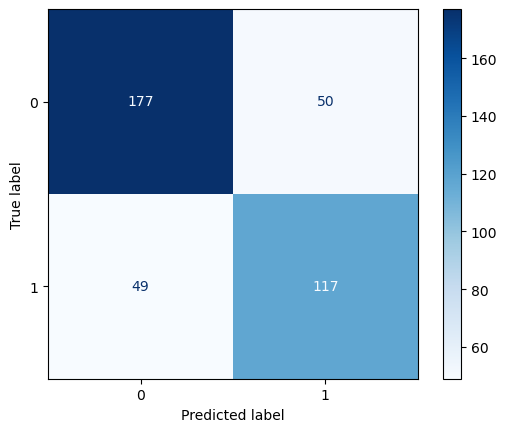

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Optimize Threshold

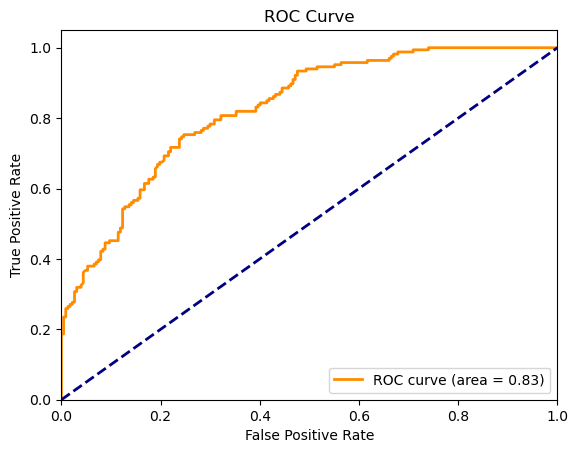

Optimal threshold: 0.4605210934557429


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, auc, f1_score
threshold = 0.38270717382988123
y_pred_prob = grboost.predict_proba(X_test)[:, 1] 
y_pred = np.where(y_pred_prob > threshold, 1, 0)

y_pred = np.where(y_pred_prob > threshold, 1, 0)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Find the best threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

### Use optimized threshold

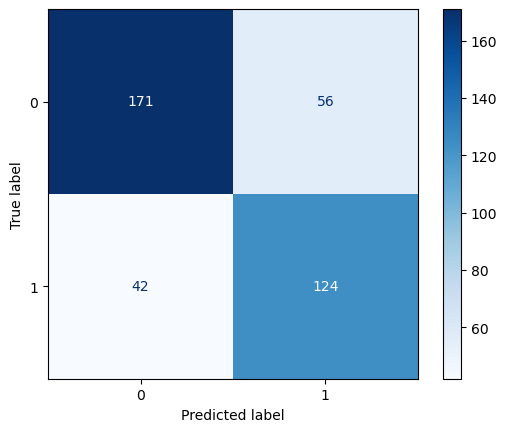

In [31]:
y_pred_prob = grboost.predict_proba(X_test)[:, 1] 

# Setting custom threshold
threshold = 0.4605210934557429

# Convert probabilities to binary predictions based on the threshold
y_pred = np.where(y_pred_prob > threshold, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Calculate accuracy

In [32]:
print("TP/(TP+FN): ",cm[1,1]/(cm[1,0]+cm[1,1]))

TP/(TP+FN):  0.7469879518072289


In [33]:
print("Accuracy: ", (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]))

Accuracy:  0.7506361323155216


### Generate a dataframe to export results into an excel spreadsheet

In [34]:
results = pd.DataFrame({
    'Predicted': y_pred,
    'Unsuccessful Strategy': y_proba[:, 0],
    'Successful Strategy': y_proba[:, 1]
})

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
prediction_results = pd.concat([X_test_reset, y_test_reset, results], axis=1)


* Export results into an excel sheet

In [35]:
prediction_results.to_excel("final_results.xlsx")

### Generate a pivot table + Fine adjustments

* Generate a pivot table

In [36]:
pivot_df = prediction_results.pivot_table(index=['circuitId', 'number_of_pitstops'], values='Successful Strategy')

* Get the most successful strategy per circuit

In [37]:
final_df = pivot_df.loc[pivot_df.groupby('circuitId')['Successful Strategy'].idxmax()]
final_df = final_df.reset_index().set_index("circuitId")

* Simplify circuits dataframe columns

In [38]:
circuits = circuits[["circuitId", "name"]]

* Give final shape to final_df

In [39]:
final_df = final_df.merge(circuits, on = "circuitId")
final_df = final_df[["name", "number_of_pitstops", "Successful Strategy"]]
final_df = final_df.rename(columns={"name":"Circuit Name", "number_of_pitstops":"Number of Pitstops",
                                   "Successful Strategy":"Prediction Strength"})
final_df = final_df.sort_values(by="Circuit Name").reset_index(drop=True)

## Calculate Execution Time of Notebook

In [40]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total execution time: {elapsed_time:.2f} seconds")

Total execution time: 212.86 seconds


<br>
<br>
<center>
  <img src="flag.png" alt="image.png" width=900>
  <h1>RESULTS</h1>
</center>

<br>
<br>

Main objective of this notebook is to answer one simple question:

"What is the optimal pit stop strategy for different tracks?"

Let's break down this statement. By analyzing historical race data for different track, we revealed advantages and uncovered valuable insights such as:

**Decision-Making Process**

* **Optimal Number of Pit Stops:** Determining how many pit stops are generally most effective for a given track. Some tracks might favor a single stop due to low tire degradation, while others might require multiple stops.
* **Strategy Planning:** Before the race, teams can develop a detailed pit stop strategy based on predicted tire degradation rates, expected weather conditions, and historical data from similar races.
* **Competitive Edge:** By having a data-driven approach, teams can anticipate and react to race developments more effectively than their competitors who might rely more on intuition or less comprehensive data analysis.

**Improved Race Performance**

* **Reduced Lap Times:** Minimize the time spent in the pits and ensure that drivers are always on the optimal tires for the current track conditions.
* **Better Tire Management:** Ensure that drivers have the best possible grip and performance throughout the race, reducing the risk of tire failures or excessive degradation.
* **Effective Overtaking:** Time pit stops to avoid getting stuck in traffic, thus allowing drivers to maintain or improve their positions during the race.
* **Adaptability:** Quickly adapt to changing conditions (e.g., sudden weather changes, safety car deployments), ensuring that the team’s strategy remains optimal throughout the race.

**Competitiveness**

* **Consistent Results:** Achieve more consistent and predictable race outcomes by minimizing the variables that can negatively impact performance.
* **Points and Standings:** Accumulate more points in the championship standings through better race finishes, which can be crucial for both drivers’ and constructors’ championships.
* **Driver Confidence:** Provide drivers with a clear and well-supported strategy, boosting their confidence and enabling them to focus on driving rather than worrying about tire wear or pit stop timings.

<br>

## Optimal Number of Pitstops per each circuit:

These insights to guide real-world pitstop strategy planning, considering factors like tire degradation rates, typical race conditions at each circuit, and weather conditions.

<br>

In [41]:
final_df

,Circuit Name,Number of Pitstops,Prediction Strength
0,Albert Park Grand Prix Circuit,2,0.390492
1,Autodromo Nazionale di Monza,2,0.588236
2,Autódromo Hermanos Rodríguez,2,0.583187
3,Autódromo Internacional do Algarve,3,0.419986
4,Autódromo José Carlos Pace,3,0.522264
5,Bahrain International Circuit,1,0.713769
6,Baku City Circuit,3,0.681051
7,Buddh International Circuit,2,0.597211
8,Circuit Gilles Villeneuve,2,0.483104
9,Circuit Paul Ricard,1,0.982263


## Frequency of most successful Pitstop Strategy

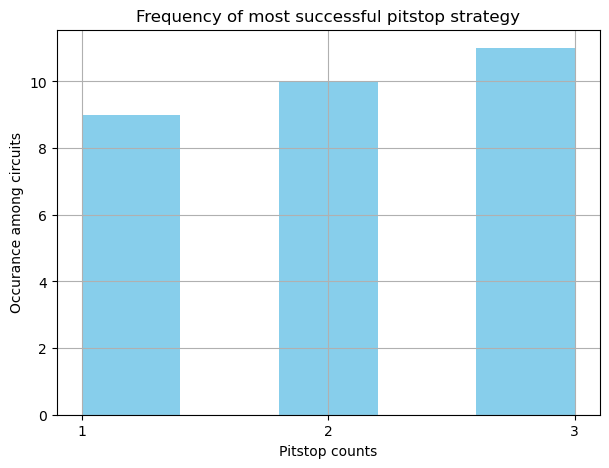

In [42]:
plt.figure(figsize=(7,5))
plt.hist(final_df["Number of Pitstops"], bins = 5, color="skyblue")
plt.title("Frequency of most successful pitstop strategy")
plt.xlabel("Pitstop counts")
plt.ylabel("Occurance among circuits")
plt.xticks([1, 2, 3])
plt.grid(True)
plt.show()